In [33]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import dask.dataframe as dd
from dask.distributed import Client
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [3]:
c = Client()
c

Client Scheduler: tcp://127.0.0.1:39482 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 34.36 GB


In [4]:
def parse(f):
    for l in gzip.open(f):
        yield eval(l)

In [7]:
filepath= "/dataset"

In [8]:
files = [f for f in listdir(filepath) if isfile(join(filepath, f))]
files

NameError: name 'listdir' is not defined

## Plist

In [6]:
plist_hist_path = filepath + 'plist_process_resource_util_hist.csv001.gz'
plist_hist = pd.read_csv(plist_hist_path, nrows=3000000, compression='gzip', sep='\t')
plist_hist.head()

,load_ts,batch_id,audit_zip,audit_internal_path,guid,interval_start_utc,interval_end_utc,interval_local_start,interval_local_end,ts,...,page_faults,hard_page_faults,disk_read_iobytes,disk_write_iobytes,tcpip_sendbytes,tcpip_receivebytes,udpip_sendbytes,udpip_receivebytes,avg_memory,peak_memory
0,2019-10-27 04:18:53,20191026-210555,2019102613-i-0728cf8ab79db9e58-BWQBS6dNb6kotNg...,V8PLIST_20191026164535.V8,189edb26714340028140631a83a09147,2019-10-25 13:43:43,2019-10-26 13:45:52,2019-10-25 16:43:43,2019-10-26 16:45:52,2019-10-25 16:45:43,...,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-10-26 04:08:28,20191025-210226,2019102520-i-04a9a906e1cd5620c-kJTLQLoksOPH6dx...,V8PLIST_20191025220758.V8,1a5db163364841b58ee19fb2fa567c45,2019-10-24 20:07:46,2019-10-25 20:08:15,2019-10-24 22:07:46,2019-10-25 22:08:15,2019-10-25 00:02:18,...,4640.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,2987.5,8312.0
2,2019-10-26 04:08:28,20191025-210226,2019102520-i-04a9a906e1cd5620c-kJTLQLoksOPH6dx...,V8PLIST_20191025220758.V8,1a5db163364841b58ee19fb2fa567c45,2019-10-24 20:07:46,2019-10-25 20:08:15,2019-10-24 22:07:46,2019-10-25 22:08:15,2019-10-25 22:08:09,...,15475.0,5.0,96256.0,0.0,0.0,0.0,0.0,0.0,27927.0,31660.0
3,2019-10-26 04:08:28,20191025-210226,2019102520-i-04a9a906e1cd5620c-kJTLQLoksOPH6dx...,V8PLIST_20191025220758.V8,1a5db163364841b58ee19fb2fa567c45,2019-10-24 20:07:46,2019-10-25 20:08:15,2019-10-24 22:07:46,2019-10-25 22:08:15,2019-10-25 12:26:00,...,11751.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,27859.0,32628.0
4,2019-10-26 04:08:28,20191025-210226,2019102520-i-04a9a906e1cd5620c-kJTLQLoksOPH6dx...,V8PLIST_20191025220758.V8,1a5db163364841b58ee19fb2fa567c45,2019-10-24 20:07:46,2019-10-25 20:08:15,2019-10-24 22:07:46,2019-10-25 22:08:15,2019-10-25 00:02:18,...,6204.0,55.0,225792.0,0.0,0.0,0.0,0.0,0.0,10298.0,29216.0


In [48]:
plist_hist.columns

Index(['load_ts', 'batch_id', 'audit_zip', 'audit_internal_path', 'guid',
       'interval_start_utc', 'interval_end_utc', 'interval_local_start',
       'interval_local_end', 'ts', 'start_dt', 'proc_name', 'exe_hash',
       'num_runs', 'ttl_run_tm_in_ms', 'cpu_user_sec', 'cpu_kernel_sec',
       'io_bytes_read', 'io_bytes_write', 'io_bytes_other', 'page_faults',
       'hard_page_faults', 'disk_read_iobytes', 'disk_write_iobytes',
       'tcpip_sendbytes', 'tcpip_receivebytes', 'udpip_sendbytes',
       'udpip_receivebytes', 'avg_memory', 'peak_memory'],
      dtype='object')

In [49]:
plist_hist['key'] = plist_hist['guid'] + ' '+plist_hist['batch_id']

In [50]:
plist_hist.groupby('key').sum()

,num_runs,ttl_run_tm_in_ms,cpu_user_sec,cpu_kernel_sec,io_bytes_read,io_bytes_write,io_bytes_other,page_faults,hard_page_faults,disk_read_iobytes,disk_write_iobytes,tcpip_sendbytes,tcpip_receivebytes,udpip_sendbytes,udpip_receivebytes,avg_memory,peak_memory
key,,,,,,,,,,,,,,,,,
000014861c7148f0ad23307a0f38e868 20191025-210226,59,92415354,8131.000000,100.000000,5.953763e+07,1.912498e+07,3.935052e+07,506627.0,93921.0,4.273715e+07,2.476902e+07,173435.0,9.782180e+05,25583.0,1.301670e+05,5.085550e+05,683548.0
000014861c7148f0ad23307a0f38e868 20191030-210210,1063,155415714,59.766008,69.375491,1.788668e+09,2.526969e+08,1.310235e+10,4904025.0,64464.0,1.339497e+09,1.237970e+08,4446058.0,5.917869e+07,37235.0,5.227390e+05,1.279122e+06,2869528.0
00001b53d8c64a4ba0a6c3c0c42f5fae 20191026-210555,4771,6394033778,284185.812131,10309.000000,2.527839e+10,1.302647e+10,4.531236e+10,109225238.0,275294.0,5.083740e+10,4.930866e+10,77001229.0,2.875356e+09,44085092.0,1.262052e+09,1.873541e+06,7328484.0
000080d2f98b4f248bb4bffd829527be 20191017-210225,594,8108321986,900.296763,1133.765547,1.913409e+10,9.920215e+08,1.892090e+09,19915676.0,102144.0,5.209816e+10,4.918378e+10,11989060.0,5.741624e+06,329275.0,6.722271e+06,4.851928e+05,1552012.0
000080d2f98b4f248bb4bffd829527be 20191018-210223,435,6509934747,700.968563,359.406155,1.178683e+10,4.022747e+08,8.616553e+08,5458183.0,39787.0,1.251174e+09,7.630541e+07,10042015.0,5.812822e+06,395136.0,7.545433e+06,1.001043e+04,212700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffb0425bd12c4d0aabb3ee2fd83006ee 20191021-210443,951,7707366219,444.000000,576.719040,3.085688e+09,1.223193e+09,7.870492e+08,27517042.0,13762.0,4.858726e+08,1.750948e+08,34200286.0,3.279789e+07,2912070.0,1.456847e+07,8.096474e+05,1839916.0
ffd6d258ec5f47c3b56eb7fe80c736ed 20191018-210223,338,262222767,5479.000000,379.000000,1.799284e+09,6.888509e+08,2.113242e+10,5380844.0,85640.0,1.362546e+09,2.353725e+08,2263845.0,1.369517e+07,186598.0,1.845165e+06,4.226748e+06,7189116.0
ffd6d258ec5f47c3b56eb7fe80c736ed 20191022-210226,550,143652131,64.000000,114.500053,2.653495e+09,1.095111e+09,8.833961e+09,6911255.0,156719.0,3.216524e+09,3.917486e+08,1821592.0,6.980016e+07,1089038.0,2.652806e+07,3.961407e+06,6510296.0


## Wait

In [7]:
wait_path = filepath + 'mousewait.csv000.gz'
wait = pd.read_csv(wait_path, nrows=500000, compression='gzip', sep='\t')
wait.head()

,load_ts,batch_id,audit_zip,audit_internal_path,guid,interval_start_utc,interval_end_utc,interval_local_start,interval_local_end,ts,dt,wait_msecs
0,2019-10-16 04:14:10,20191015-210431,2019101508-i-04a9a906e1cd5620c-mwKSBh69JN7Be4d...,V8WAIT_20191014093021.V8,000191350c96450d9a3abe474651ca64,2019-10-12 08:04:27,2019-10-14 08:30:35,2019-10-12 09:04:27,2019-10-14 09:30:35,2019-10-12 14:05:49,2019-10-12,1200
1,2019-10-16 04:14:10,20191015-210431,2019101508-i-04a9a906e1cd5620c-39jBWoAs1p6xBP9...,V8WAIT_20191015093025.V8,000191350c96450d9a3abe474651ca64,2019-10-14 08:31:01,2019-10-15 08:30:52,2019-10-14 09:31:01,2019-10-15 09:30:52,2019-10-14 15:15:47,2019-10-14,2401
2,2019-10-16 04:14:10,20191015-210431,2019101508-i-04a9a906e1cd5620c-39jBWoAs1p6xBP9...,V8WAIT_20191015093025.V8,000191350c96450d9a3abe474651ca64,2019-10-14 08:31:01,2019-10-15 08:30:52,2019-10-14 09:31:01,2019-10-15 09:30:52,2019-10-14 17:15:38,2019-10-14,5000
3,2019-10-16 04:14:10,20191015-210431,2019101508-i-04a9a906e1cd5620c-39jBWoAs1p6xBP9...,V8WAIT_20191015093025.V8,000191350c96450d9a3abe474651ca64,2019-10-14 08:31:01,2019-10-15 08:30:52,2019-10-14 09:31:01,2019-10-15 09:30:52,2019-10-14 17:19:44,2019-10-14,2000
4,2019-10-16 04:14:10,20191015-210431,2019101508-i-04a9a906e1cd5620c-39jBWoAs1p6xBP9...,V8WAIT_20191015093025.V8,000191350c96450d9a3abe474651ca64,2019-10-14 08:31:01,2019-10-15 08:30:52,2019-10-14 09:31:01,2019-10-15 09:30:52,2019-10-14 17:19:46,2019-10-14,3300


## Combine

In [43]:
plist_guids = plist_hist['guid'].value_counts().index
print('plist_guids: '+ str(len(plist_guids)))

plist_guids: 14539


In [9]:
wait_guids = wait['guid'].value_counts().index
len(wait_guids)

1175

In [10]:
common_guid = list(set(plist_hist['guid'].value_counts().index) & set(wait['guid'].value_counts().index))
len(common_guid)

100

In [44]:
print('plist_guids: '+ str(len(plist_guids)))
print('wait_guids: '+ str(len(wait_guids)))
print('common_guids: '+ str(len(common_guid)))

plist_guids: 14539
wait_guids: 1175
common_guids: 100


In [46]:
print('common_keys: '+ '80')

common_keys: 80


In [11]:
plist_user_one = plist_hist[plist_hist['guid'] == common_guid[0]]
plist_user_one.head().transpose()

,2081111,2081112,2081113,2081114,2081115
load_ts,2019-11-03 07:32:36,2019-11-03 07:32:36,2019-11-02 04:07:49,2019-11-03 07:32:36,2019-11-02 04:07:49
batch_id,20191102-210224,20191102-210224,20191101-210226,20191102-210224,20191101-210226
audit_zip,2019110217-i-040171543e1bfef37-BmiZKQACF4095Dd...,2019110217-i-040171543e1bfef37-BmiZKQACF4095Dd...,2019110117-i-0728cf8ab79db9e58-NXuGO6LXCDIZQu7...,2019110217-i-040171543e1bfef37-BmiZKQACF4095Dd...,2019110117-i-0728cf8ab79db9e58-NXuGO6LXCDIZQu7...
audit_internal_path,V8PLIST_20191102203612.V8,V8PLIST_20191102203612.V8,V8PLIST_20191101203601.V8,V8PLIST_20191102203612.V8,V8PLIST_20191101203601.V8
guid,0006a4e301544f9a801c4b28eb25421b,0006a4e301544f9a801c4b28eb25421b,0006a4e301544f9a801c4b28eb25421b,0006a4e301544f9a801c4b28eb25421b,0006a4e301544f9a801c4b28eb25421b
interval_start_utc,2019-11-01 17:36:09,2019-11-01 17:36:09,2019-10-31 11:43:05,2019-11-01 17:36:09,2019-10-31 11:43:05
interval_end_utc,2019-11-02 17:36:25,2019-11-02 17:36:25,2019-11-01 17:36:11,2019-11-02 17:36:25,2019-11-01 17:36:11
interval_local_start,2019-11-01 20:36:09,2019-11-01 20:36:09,2019-10-31 14:43:05,2019-11-01 20:36:09,2019-10-31 14:43:05
interval_local_end,2019-11-02 20:36:25,2019-11-02 20:36:25,2019-11-01 20:36:11,2019-11-02 20:36:25,2019-11-01 20:36:11
ts,2019-11-01 23:58:38,2019-11-01 22:01:53,2019-11-01 04:40:52,2019-11-01 23:03:57,2019-11-01 20:36:06


In [12]:
wait_user_one = wait[wait['guid'] == common_guid[0]]
wait_user_one.head()

,load_ts,batch_id,audit_zip,audit_internal_path,guid,interval_start_utc,interval_end_utc,interval_local_start,interval_local_end,ts,dt,wait_msecs
439664,2019-10-11 04:08:57,20191010-210225,2019101004-i-04a9a906e1cd5620c-s7xAwI1S3IahJTy...,V8WAIT_20191010071001.V8,0006a4e301544f9a801c4b28eb25421b,2019-10-09 04:08:26,2019-10-10 04:10:11,2019-10-09 07:08:26,2019-10-10 07:10:11,2019-10-09 14:10:41,2019-10-09,4600
439665,2019-10-11 04:08:57,20191010-210225,2019101004-i-04a9a906e1cd5620c-s7xAwI1S3IahJTy...,V8WAIT_20191010071001.V8,0006a4e301544f9a801c4b28eb25421b,2019-10-09 04:08:26,2019-10-10 04:10:11,2019-10-09 07:08:26,2019-10-10 07:10:11,2019-10-09 21:12:05,2019-10-09,1599
439666,2019-10-11 04:08:57,20191010-210225,2019101004-i-04a9a906e1cd5620c-s7xAwI1S3IahJTy...,V8WAIT_20191010071001.V8,0006a4e301544f9a801c4b28eb25421b,2019-10-09 04:08:26,2019-10-10 04:10:11,2019-10-09 07:08:26,2019-10-10 07:10:11,2019-10-10 00:30:31,2019-10-10,1701
439667,2019-10-12 04:08:44,20191011-210226,2019101104-i-040171543e1bfef37-9tSl6ir8o5uN01A...,V8WAIT_20191011073207.V8,0006a4e301544f9a801c4b28eb25421b,2019-10-10 04:10:09,2019-10-11 04:32:18,2019-10-10 07:10:09,2019-10-11 07:32:18,2019-10-11 01:34:23,2019-10-11,1200
439668,2019-10-12 04:08:44,20191011-210226,2019101104-i-040171543e1bfef37-9tSl6ir8o5uN01A...,V8WAIT_20191011073207.V8,0006a4e301544f9a801c4b28eb25421b,2019-10-10 04:10:09,2019-10-11 04:32:18,2019-10-10 07:10:09,2019-10-11 07:32:18,2019-10-11 01:50:09,2019-10-11,1900


In [13]:
temp = pd.to_datetime(wait_user_one['interval_end_utc']) - pd.to_datetime(wait_user_one['interval_start_utc'])

In [14]:
temp.apply(lambda x: x.seconds).value_counts()

154      13
214      11
18778     7
78        7
5698      7
712       6
16        5
11019     4
13        4
12886     4
5777      4
4477      4
444       3
3745      3
12466     3
105       3
50        2
1329      2
3756      2
30        2
12101     2
71        2
23        2
52544     1
21186     1
29        1
5448      1
107       1
13303     1
33535     1
dtype: int64

## Feature Process

In [15]:
plist_hist['common'] = plist_hist['guid'].apply(lambda x: x in common_guid)
plist_hist_common = plist_hist[plist_hist['common']]

In [16]:
wait['common'] = wait['guid'].apply(lambda x: x in common_guid)
wait_common = wait[wait['common']]

In [17]:
plist_hist_common['key'] = plist_hist_common['guid'] + plist_hist_common['batch_id']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
wait_common['key'] = wait_common['guid'] + wait_common['batch_id']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
wait_common = wait_common[['key', 'wait_msecs']]

In [20]:
merged_df = pd.merge(plist_hist_common, wait_common, on = 'key')

In [21]:
pro_df = merged_df.groupby('key').sum()

In [22]:
#pro_df = pro_df.apply(lambda x: x / pro_df['ttl_run_tm_in_ms'])

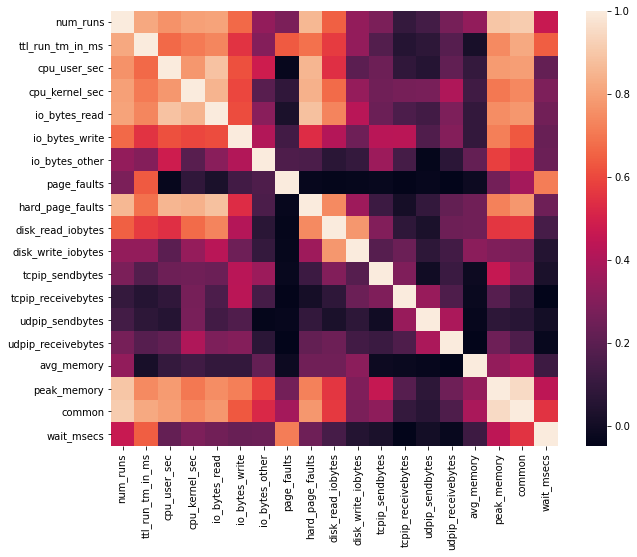

In [23]:
plt.figure(figsize=(10, 8))
sns.heatmap(pro_df.corr())

In [26]:
cor = pro_df.corr()['wait_msecs']
cor[cor > 0.4].drop(['common', 'wait_msecs'])

num_runs            0.464598
ttl_run_tm_in_ms    0.647657
page_faults         0.716664
peak_memory         0.441339
Name: wait_msecs, dtype: float64

Text(0.5, 0, 'log of num runs')

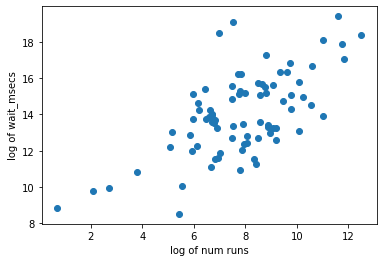

In [36]:
plt.scatter(np.log(pro_df['num_runs']),np.log(pro_df['wait_msecs']),)
plt.ylabel("log of wait_msecs",fontsize=10)
plt.xlabel("log of num runs",fontsize=10)

In [34]:
reg = linear_model.LinearRegression()
reg.fit(np.log(pro_df['num_runs'], np.log(pro_df['wait_msecs'])))

RecursionError: maximum recursion depth exceeded

Text(0.5, 0, 'log of ttl_run_tm_in_ms')

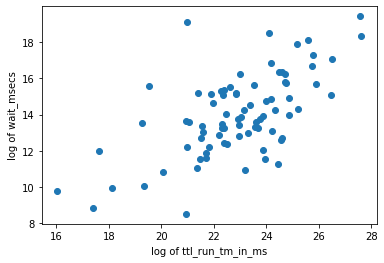

In [39]:
plt.scatter(np.log(pro_df['ttl_run_tm_in_ms']),np.log(pro_df['wait_msecs']))
plt.ylabel("log of wait_msecs",fontsize=10)
plt.xlabel("log of ttl_run_tm_in_ms",fontsize=10)

Text(0.5, 0, 'log of page_faults')

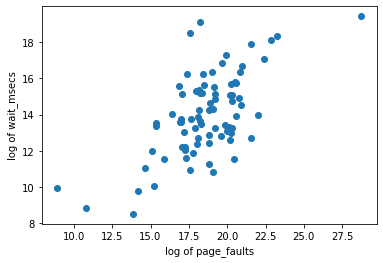

In [40]:
plt.scatter(np.log(pro_df['page_faults']),np.log(pro_df['wait_msecs']))
plt.ylabel("log of wait_msecs",fontsize=10)
plt.xlabel('log of page_faults',fontsize=10)

Text(0.5, 0, 'log of peak_memory')

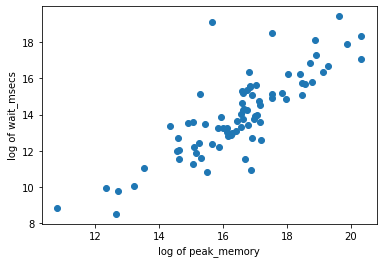

In [41]:
plt.scatter(np.log(pro_df['peak_memory']),np.log(pro_df['wait_msecs']))
plt.ylabel("log of wait_msecs",fontsize=10)
plt.xlabel('log of peak_memory',fontsize=10)

In [ ]:
with ProgressBar():
    a = df.compute()
a

## All

In [9]:
filepath = 'dataset/'
wait_all_path = filepath + 'mousewait_all.csv001.gz'
wait_all = pd.read_csv(wait_all_path, nrows=500000, compression='gzip',sep = '\x01', error_bad_lines = False)
wait_all.head()

,load_ts,batch_id,audit_zip,audit_internal_path,guid,interval_start_utc,interval_end_utc,interval_local_start,interval_local_end,ts,...,after_cpuutil_max,after_harddpf_mean,after_harddpf_min,after_harddpf_max,after_diskutil_mean,after_diskutil_min,after_diskutil_max,after_networkutil_mean,after_networkutil_min,after_networkutil_max
0,2020-02-17 04:14:15,20200216-200527,2020021515-i-0728cf8ab79db9e58-0PQzvFr53c0KKhn...,V8WAIT_20200215225003.V8,ec601c5d312847a68f2346944dbf7433,2020-02-14 15:49:11,2020-02-15 15:51:30,2020-02-14 22:49:11,2020-02-15 22:51:30,2020-02-14 23:06:07,...,63.653845,32975.522486,14414.729578,109379.546298,6.996697e+06,4.424675e+06,1.669766e+07,160113.666050,10555.214421,7.005273e+05
1,2020-02-17 04:14:15,20200216-200527,2020021515-i-0728cf8ab79db9e58-0PQzvFr53c0KKhn...,V8WAIT_20200215225003.V8,ec601c5d312847a68f2346944dbf7433,2020-02-14 15:49:11,2020-02-15 15:51:30,2020-02-14 22:49:11,2020-02-15 22:51:30,2020-02-14 23:36:14,...,52.734400,23418.144640,1118.973930,78629.416961,1.603042e+06,1.966386e+04,8.046177e+06,10087.796235,2286.012122,1.363990e+04
2,2020-02-17 04:14:15,20200216-200527,2020021515-i-0728cf8ab79db9e58-0PQzvFr53c0KKhn...,V8WAIT_20200215225003.V8,ec601c5d312847a68f2346944dbf7433,2020-02-14 15:49:11,2020-02-15 15:51:30,2020-02-14 22:49:11,2020-02-15 22:51:30,2020-02-15 00:17:33,...,58.965876,23912.363263,1737.067429,116903.898039,2.141939e+06,3.277305e+04,9.064737e+06,12314.223147,8185.584133,2.340836e+04
3,2020-02-17 04:14:15,20200216-200527,2020021515-i-0728cf8ab79db9e58-0PQzvFr53c0KKhn...,V8WAIT_20200215225003.V8,ec601c5d312847a68f2346944dbf7433,2020-02-14 15:49:11,2020-02-15 15:51:30,2020-02-14 22:49:11,2020-02-15 22:51:30,2020-02-15 00:53:26,...,34.951303,21957.671636,530.575343,113020.664224,1.552810e+06,3.153773e+04,6.460560e+06,8264.801956,2176.351066,1.344384e+04
4,2020-02-17 04:14:15,20200216-200527,2020021515-i-0728cf8ab79db9e58-0PQzvFr53c0KKhn...,V8WAIT_20200215225003.V8,ec601c5d312847a68f2346944dbf7433,2020-02-14 15:49:11,2020-02-15 15:51:30,2020-02-14 22:49:11,2020-02-15 22:51:30,2020-02-15 21:02:01,...,64.355809,46216.966367,22111.284672,110219.798541,6.959890e+06,2.837489e+06,1.672723e+07,474115.187358,22557.075868,2.653365e+06


In [152]:
subset_wait_all = wait_all.head(1000)

In [153]:
subset_wait_all.transpose()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
load_ts,2020-02-17 04:14:15,2020-02-17 04:14:15,2020-02-17 04:14:15,2020-02-17 04:14:15,2020-02-17 04:14:15,2020-02-17 04:14:15,2020-02-17 04:14:15,2020-02-17 04:14:15,2020-02-17 04:14:15,2020-02-17 04:14:15,...,2020-11-28 03:11:24,2020-11-28 03:11:24,2020-11-28 03:11:24,2020-11-28 03:11:24,2020-11-28 03:11:24,2020-11-28 03:11:24,2020-11-28 03:11:24,2020-11-28 03:11:24,2020-11-28 03:11:24,2020-11-28 03:11:24
batch_id,20200216-200527,20200216-200527,20200216-200527,20200216-200527,20200216-200527,20200216-200527,20200216-200527,20200216-200527,20200216-200527,20200216-200527,...,20201127-190229,20201127-190229,20201127-190229,20201127-190229,20201127-190229,20201127-190229,20201127-190229,20201127-190229,20201127-190229,20201127-190229
audit_zip,2020021515-i-0728cf8ab79db9e58-0PQzvFr53c0KKhn...,2020021515-i-0728cf8ab79db9e58-0PQzvFr53c0KKhn...,2020021515-i-0728cf8ab79db9e58-0PQzvFr53c0KKhn...,2020021515-i-0728cf8ab79db9e58-0PQzvFr53c0KKhn...,2020021515-i-0728cf8ab79db9e58-0PQzvFr53c0KKhn...,2020021515-i-0728cf8ab79db9e58-0PQzvFr53c0KKhn...,2020021515-i-0728cf8ab79db9e58-0PQzvFr53c0KKhn...,2020021615-i-04a9a906e1cd5620c-YNVr6Q1BYXuv83g...,2020021615-i-04a9a906e1cd5620c-YNVr6Q1BYXuv83g...,2020021615-i-04a9a906e1cd5620c-YNVr6Q1BYXuv83g...,...,2020112708-i-04a9a906e1cd5620c-kVfiEtI9iDkHUdx...,2020112708-i-04a9a906e1cd5620c-kVfiEtI9iDkHUdx...,2020112708-i-04a9a906e1cd5620c-kVfiEtI9iDkHUdx...,2020112708-i-04a9a906e1cd5620c-kVfiEtI9iDkHUdx...,2020112708-i-04a9a906e1cd5620c-kVfiEtI9iDkHUdx...,2020112708-i-04a9a906e1cd5620c-kVfiEtI9iDkHUdx...,2020112708-i-04a9a906e1cd5620c-kVfiEtI9iDkHUdx...,2020112708-i-04a9a906e1cd5620c-kVfiEtI9iDkHUdx...,2020112708-i-04a9a906e1cd5620c-kVfiEtI9iDkHUdx...,2020112708-i-04a9a906e1cd5620c-kVfiEtI9iDkHUdx...
audit_internal_path,V8WAIT_20200215225003.V8,V8WAIT_20200215225003.V8,V8WAIT_20200215225003.V8,V8WAIT_20200215225003.V8,V8WAIT_20200215225003.V8,V8WAIT_20200215225003.V8,V8WAIT_20200215225003.V8,V8WAIT_20200216225134.V8,V8WAIT_20200216225134.V8,V8WAIT_20200216225134.V8,...,V8WAIT_20201127094151.V8,V8WAIT_20201127094151.V8,V8WAIT_20201127094151.V8,V8WAIT_20201127094151.V8,V8WAIT_20201127094151.V8,V8WAIT_20201127094151.V8,V8WAIT_20201127094151.V8,V8WAIT_20201127094151.V8,V8WAIT_20201127094151.V8,V8WAIT_20201127094151.V8
guid,ec601c5d312847a68f2346944dbf7433,ec601c5d312847a68f2346944dbf7433,ec601c5d312847a68f2346944dbf7433,ec601c5d312847a68f2346944dbf7433,ec601c5d312847a68f2346944dbf7433,ec601c5d312847a68f2346944dbf7433,ec601c5d312847a68f2346944dbf7433,ec601c5d312847a68f2346944dbf7433,ec601c5d312847a68f2346944dbf7433,ec601c5d312847a68f2346944dbf7433,...,c75cd100df78461cb063072f158dbacb,c75cd100df78461cb063072f158dbacb,c75cd100df78461cb063072f158dbacb,c75cd100df78461cb063072f158dbacb,c75cd100df78461cb063072f158dbacb,c75cd100df78461cb063072f158dbacb,c75cd100df78461cb063072f158dbacb,c75cd100df78461cb063072f158dbacb,c75cd100df78461cb063072f158dbacb,c75cd100df78461cb063072f158dbacb
interval_start_utc,2020-02-14 15:49:11,2020-02-14 15:49:11,2020-02-14 15:49:11,2020-02-14 15:49:11,2020-02-14 15:49:11,2020-02-14 15:49:11,2020-02-14 15:49:11,2020-02-15 15:51:29,2020-02-15 15:51:29,2020-02-15 15:51:29,...,2020-11-26 08:40:34,2020-11-26 08:40:34,2020-11-26 08:40:34,2020-11-26 08:40:34,2020-11-26 08:40:34,2020-11-26 08:40:34,2020-11-26 08:40:34,2020-11-26 08:40:34,2020-11-26 08:40:34,2020-11-26 08:40:34
interval_end_utc,2020-02-15 15:51:30,2020-02-15 15:51:30,2020-02-15 15:51:30,2020-02-15 15:51:30,2020-02-15 15:51:30,2020-02-15 15:51:30,2020-02-15 15:51:30,2020-02-16 15:52:46,2020-02-16 15:52:46,2020-02-16 15:52:46,...,2020-11-27 08:42:06,2020-11-27 08:42:06,2020-11-27 08:42:06,2020-11-27 08:42:06,2020-11-27 08:42:06,2020-11-27 08:42:06,2020-11-27 08:42:06,2020-11-27 08:42:06,2020-11-27 08:42:06,2020-11-27 08:42:06
interval_local_start,2020-02-14 22:49:11,2020-02-14 22:49:11,2020-02-14 22:49:11,2020-02-14 22:49:11,2020-02-14 22:49:11,2020-02-14 22:49:1

In [154]:
plt.hist(subset_wait_all.wait_msecs)
plt.xlabel("wait_msecs",fontsize=10)
plt.ylabel("Count",fontsize=10)

Text(0.0556047010727544, -0.07165639563903628, 'Count')

In [10]:
subset_wait_all.wait_msecs.value_counts(bins = 3000)

(-26842.567, 10282.189]         973
(10282.189, 19563.377]           13
(19563.377, 28844.566]            8
(56688.132, 65969.321]            2
(28844.566, 38125.755]            2
                               ... 
(18489128.824, 18498410.013]      0
(18479847.635, 18489128.824]      0
(18470566.447, 18479847.635]      0
(18461285.258, 18470566.447]      0
(13913502.811, 13922784.0]        0
Name: wait_msecs, Length: 3000, dtype: int64

In [11]:
cpu_util_threshold = 100
wait_threshold = 1E4
subset_one = subset_wait_all[['before_cpuutil_max', 'wait_msecs', 'before_harddpf_max', 'before_diskutil_max', 'before_networkutil_max']]
subset_one = subset_one[subset_one.before_cpuutil_max < cpu_util_threshold]
subset_one = subset_one[subset_one.wait_msecs < wait_threshold]
subset_one['before_harddpf_max'] = np.log(subset_one['before_harddpf_max'])
subset_one['before_diskutil_max'] = np.log(subset_one['before_diskutil_max'])
subset_one['before_networkutil_max'] = np.log(subset_one['before_networkutil_max'])

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
subset_one.wait_msecs.value_counts(bins = 10)

(992.202, 1880.7]    428
(3640.1, 4519.8]     153
(2760.4, 3640.1]     141
(5399.5, 6279.2]      68
(6279.2, 7158.9]      47
(4519.8, 5399.5]      45
(1880.7, 2760.4]      41
(8038.6, 8918.3]      23
(8918.3, 9798.0]      10
(7158.9, 8038.6]      10
Name: wait_msecs, dtype: int64

In [13]:
subset_one.wait_msecs.value_counts(bins = 10).sum()

966

Text(0, 0.5, 'Count')

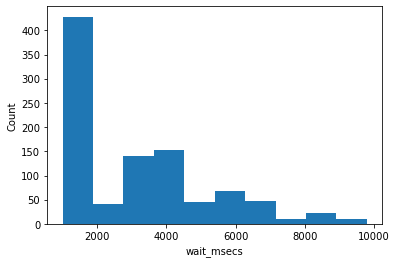

In [16]:
plt.hist(subset_one.wait_msecs)
plt.xlabel("wait_msecs",fontsize=10)
plt.ylabel("Count",fontsize=10)

Text(0, 0.5, 'wait_msecs')

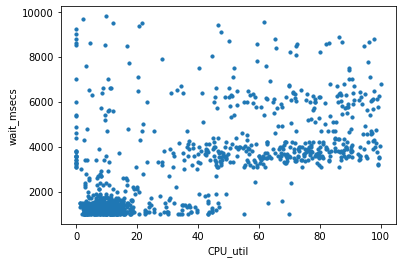

In [17]:
plt.scatter(subset_one.before_cpuutil_max, subset_one.wait_msecs, s = 10)
plt.xlabel("CPU_util",fontsize=10)
plt.ylabel("wait_msecs",fontsize=10)

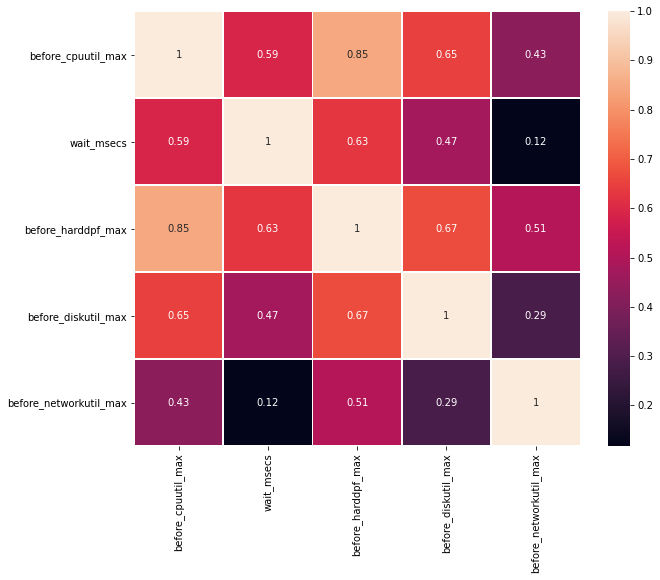

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(subset_one.corr(), annot=True, linewidths=.5)

In [19]:
subset_one = subset_one.drop('before_networkutil_max', axis = 1)

In [20]:
subset_one = subset_one.apply(lambda x: x.apply(lambda y: 0 if y < 0 else y))

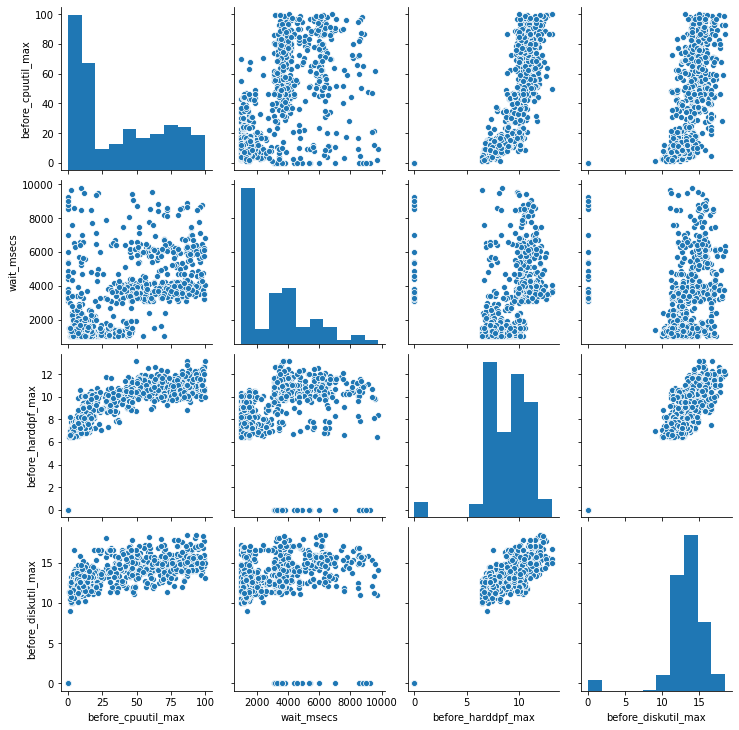

In [21]:
sns.pairplot(subset_one)

In [22]:
subset_one.before_harddpf_max[subset_one.before_harddpf_max < 7].value_counts(bins = 10)

(6.3, 7.0]       89
(-0.008, 0.7]    27
(5.6, 6.3]        0
(4.9, 5.6]        0
(4.2, 4.9]        0
(3.5, 4.2]        0
(2.8, 3.5]        0
(2.1, 2.8]        0
(1.4, 2.1]        0
(0.7, 1.4]        0
Name: before_harddpf_max, dtype: int64

In [23]:
subset_one = subset_one[subset_one['before_harddpf_max'] > 5]

In [24]:
subset_one = subset_one[subset_one['before_diskutil_max'] > 5]

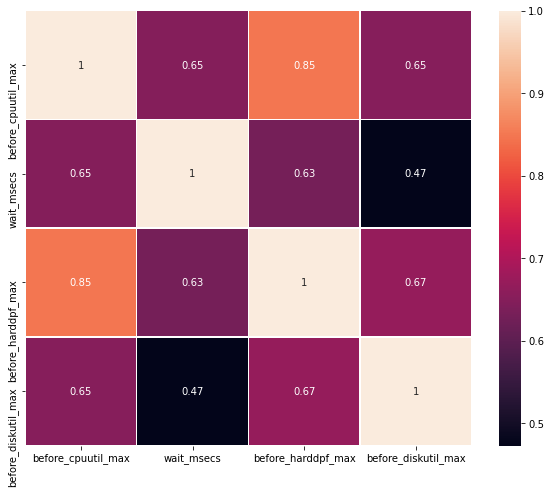

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(subset_one.corr(), annot=True, linewidths=.5)

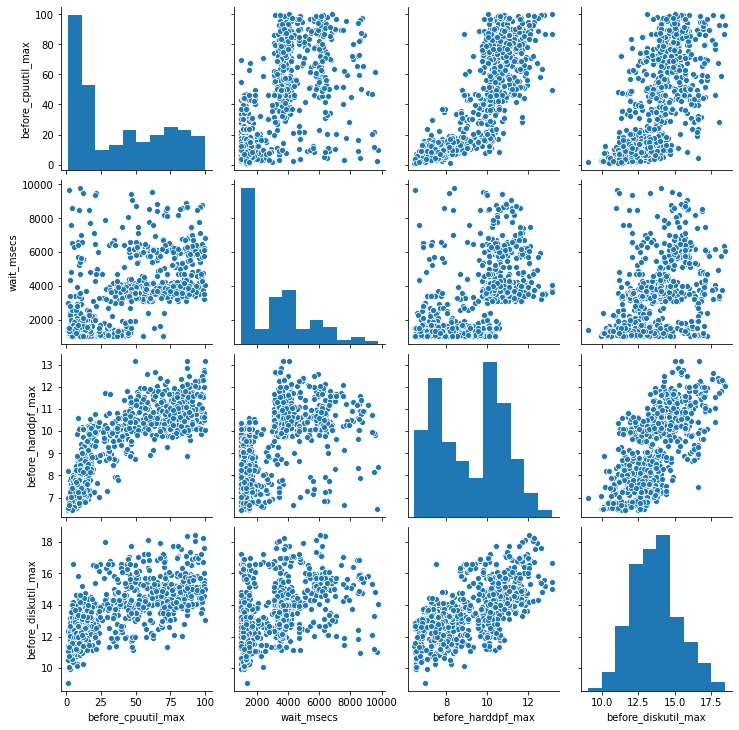

In [26]:
sns.pairplot(subset_one)

In [ ]:
plt.scatter(subset_one.before_cpuutil_max, subset_one.wait_msecs, s = 10)
plt.xlabel("CPU_util",fontsize=10)
plt.ylabel("wait_msecs",fontsize=10)

In [27]:
%matplotlib notebook

<IPython.core.display.Javascript object>


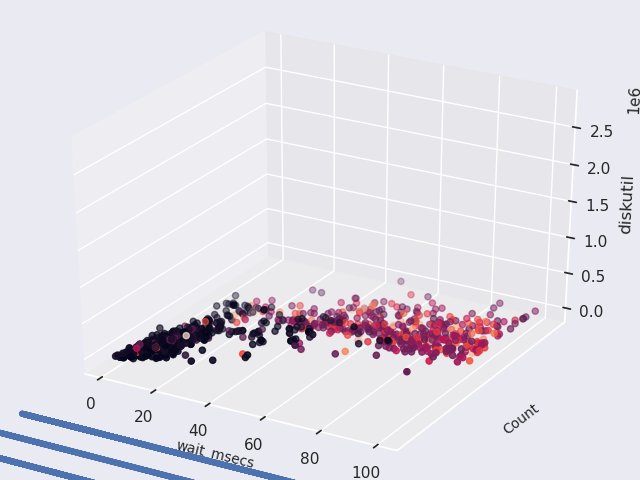

In [28]:
sns.set(style = "darkgrid")

fig = plt.figure()
ax = Axes3D(fig)

x = subset_one.before_cpuutil_max
y = subset_one.before_harddpf_max
z = subset_one.before_diskutil_max


ax.scatter(x, y, z, c=subset_one.wait_msecs, marker='o')
ax.set_xlabel('cpuutil')
ax.set_ylabel('harddpf')
ax.set_zlabel('diskutil')

plt.show()

In [29]:
subset_one

,before_cpuutil_max,wait_msecs,before_harddpf_max,before_diskutil_max
0,83.074858,8610,11.584524,15.930028
1,33.846128,4148,9.986766,11.740495
2,42.672913,4100,10.850025,14.773349
3,44.845770,3899,10.441610,13.895439
4,97.735396,8777,10.420651,14.758612
...,...,...,...,...
995,2.334923,1313,6.731831,10.735209
996,8.509668,6407,7.258483,12.644605
997,8.509668,1703,7.258483,12.644605
998,1.896251,1498,6.647446,11.304173


## Baseline

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [137]:
subset_wait_all = wait_all.head(50000)
cpu_util_threshold = 100
wait_threshold = 1E4
subset_one = subset_wait_all[['before_cpuutil_max', 'wait_msecs', 'before_harddpf_max', 'before_diskutil_max', 'before_networkutil_max']]
subset_one = subset_one[subset_one.before_cpuutil_max < cpu_util_threshold]
subset_one = subset_one[subset_one.wait_msecs < wait_threshold]
subset_one['before_harddpf_max'] = np.log(subset_one['before_harddpf_max'])
subset_one['before_diskutil_max'] = np.log(subset_one['before_diskutil_max'])
subset_one['before_networkutil_max'] = np.log(subset_one['before_networkutil_max'])

subset_one = subset_one.drop('before_networkutil_max', axis = 1)
subset_one = subset_one.apply(lambda x: x.apply(lambda y: 0 if y < 0 else y))
subset_one = subset_one[subset_one['before_harddpf_max'] > 5]
subset_one = subset_one[subset_one['before_diskutil_max'] > 5]

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [138]:
subset_one['wait_msecs'] = subset_one.wait_msecs.apply(lambda x: '0-3S' if x <= 3000 else '3-5S' if x <= 5000 else '5-7S' if x <= 7000 else '7+S')

In [139]:
train, test = train_test_split(subset_one, test_size=0.2, random_state = 180)

In [140]:
model = DecisionTreeClassifier().fit(train.drop('wait_msecs', axis = 1), train.wait_msecs)

In [141]:
prediction = model.predict(test.drop('wait_msecs', axis = 1))

In [142]:
print(metrics.classification_report(test.wait_msecs, prediction, digits=3))

              precision    recall  f1-score   support

        0-3S      0.688     0.689     0.688      4762
        3-5S      0.219     0.225     0.222      1350
        5-7S      0.133     0.128     0.130       634
         7+S      0.113     0.107     0.110       393

    accuracy                          0.519      7139
   macro avg      0.288     0.287     0.288      7139
weighted avg      0.518     0.519     0.519      7139



In [143]:
prediction = model.predict(train.drop('wait_msecs', axis = 1))

In [144]:
print(metrics.classification_report(train.wait_msecs, prediction, digits=3))

              precision    recall  f1-score   support

        0-3S      0.975     0.999     0.987     19035
        3-5S      0.988     0.944     0.965      5512
        5-7S      0.997     0.944     0.970      2460
         7+S      1.000     0.946     0.972      1549

    accuracy                          0.981     28556
   macro avg      0.990     0.958     0.974     28556
weighted avg      0.981     0.981     0.980     28556



In [150]:
for c in [7,8,9,10,11,12,13]:
    print('-------------------------------------------------')
    print('c: ' + str(c))
    model = DecisionTreeClassifier(max_depth = c).fit(train.drop('wait_msecs', axis = 1), train.wait_msecs)
    prediction = model.predict(test.drop('wait_msecs', axis = 1))
    print(metrics.classification_report(test.wait_msecs, prediction, digits=3, zero_division = False) + '\n')

-------------------------------------------------
c: 7
              precision    recall  f1-score   support

        0-3S      0.673     0.986     0.800      4762
        3-5S      0.344     0.041     0.073      1350
        5-7S      0.000     0.000     0.000       634
         7+S      0.000     0.000     0.000       393

    accuracy                          0.665      7139
   macro avg      0.254     0.257     0.218      7139
weighted avg      0.514     0.665     0.547      7139


-------------------------------------------------
c: 8
              precision    recall  f1-score   support

        0-3S      0.673     0.982     0.799      4762
        3-5S      0.362     0.050     0.088      1350
        5-7S      0.143     0.002     0.003       634
         7+S      0.000     0.000     0.000       393

    accuracy                          0.665      7139
   macro avg      0.294     0.258     0.223      7139
weighted avg      0.530     0.665     0.550      7139


------------------

## More Static System Info

In [3]:
filepath = 'dataset/'
system_path = filepath + 'system_sysinfo_unique_normalized.csv000.gz'
system = pd.read_csv(system_path, nrows=500000, compression='gzip',sep = '\x01', error_bad_lines = False)
system.head()

,load_ts,guid,chassistype,chassistype_2in1_category,countryname,countryname_normalized,modelvendor,modelvendor_normalized,model,model_normalized,...,cpu_suffix,screensize_category,persona,processor_line,vpro_enabled,firstreportdate,lastreportdate,discretegraphics,cpu_stepping,engagement_id
0,2020-10-01 00:48:15,10351643a4ae4b2d9cbc8a90db184050,Notebook,Unknown,Brazil,Brazil,Lenovo,Lenovo,Lenovo G480,Lenovo G480,...,Core-M,14x,Web User,M-Processor,N,2020-01-12 20:31:03,2020-09-29 18:30:56,N,Intel64 Family 6 Model 42 Stepping 7,iduu
1,2020-10-01 00:48:15,4f40b2f38cd74f6ea1559cebbc924619,Notebook,Unknown,Sweden,Sweden,Asus,Asus,T300CHI,T300CHI,...,Core-Y,12x,Web User,Unknown,N,2018-11-15 17:24:52,2020-09-28 12:49:29,N,Intel64 Family 6 Model 61 Stepping 4,iduu
2,2020-10-01 00:48:15,04b81eb4d661410ebff356f27fc544ed,Desktop,Unknown,Viet Nam,Viet Nam,System manufacturer,System manufacturer,System Product Name,System Product Name,...,Other,23x,Office/Productivity,Unknown,Y,2020-05-09 12:24:37,2020-09-29 08:54:35,Y,Intel64 Family 6 Model 158 Stepping 12,intel.com
3,2020-10-01 00:48:15,afd55a587fe14fc1904d572b3230dd54,Notebook,Unknown,Mexico,Mexico,HP,HP,HP ProBook 640 G2,HP ProBook 640 G2,...,Core-U,14x,Office/Productivity,U-Processor,N,2019-10-22 13:56:27,2020-09-28 08:41:47,N,Intel64 Family 6 Model 78 Stepping 3,intel.com
4,2020-10-01 00:48:15,4b3d6747c5f541949f4c1bd127b00bd9,Notebook,Unknown,Romania,Romania,Acer,Acer,Nitro AN515-52,Nitro AN515-52,...,Core-H,15x,Web User,H-Processor,N,2020-04-01 17:37:46,2020-04-23 19:34:16,Y,Intel64 Family 6 Model 158 Stepping 10,intel.com


In [4]:
system.head().transpose()

,0,1,2,3,4
load_ts,2020-10-01 00:48:15,2020-10-01 00:48:15,2020-10-01 00:48:15,2020-10-01 00:48:15,2020-10-01 00:48:15
guid,10351643a4ae4b2d9cbc8a90db184050,4f40b2f38cd74f6ea1559cebbc924619,04b81eb4d661410ebff356f27fc544ed,afd55a587fe14fc1904d572b3230dd54,4b3d6747c5f541949f4c1bd127b00bd9
chassistype,Notebook,Notebook,Desktop,Notebook,Notebook
chassistype_2in1_category,Unknown,Unknown,Unknown,Unknown,Unknown
countryname,Brazil,Sweden,Viet Nam,Mexico,Romania
countryname_normalized,Brazil,Sweden,Viet Nam,Mexico,Romania
modelvendor,Lenovo,Asus,System manufacturer,HP,Acer
modelvendor_normalized,Lenovo,Asus,System manufacturer,HP,Acer
model,Lenovo G480,T300CHI,System Product Name,HP ProBook 640 G2,Nitro AN515-52
model_normalized,Lenovo G480,T300CHI,System Product Name,HP ProBook 640 G2,Nitro AN515-52


In [5]:
len(system)

100000

In [90]:
system_filter = system[['guid', 'chassistype', 'ram', 'os', '#ofcores', 'age_category', 'graphicscardclass', 'processornumber', 'cpucode', 'persona']]

In [91]:
common_guid = set(wait_all.guid.unique()) & set(system_filter.guid.unique())

In [92]:
len(common_guid)

850

In [93]:
system_filter = system_filter[system_filter.guid.apply(lambda x: x in common_guid)]

In [94]:
system_filter

,guid,chassistype,ram,os,#ofcores,age_category,graphicscardclass,processornumber,cpucode,persona
343,cb95d6d8f1ae498cb8a381f6597c41c2,Notebook,16.000000,Win10,4.0,6+ years,Low-End Graphics Cards,22 nm,i7-4700HQ,Casual User
405,f6cf5e3aaeb249e1bd704ded551cbf1c,Notebook,8.015625,Win10,2.0,4-5 years,Low-Midrange Graphics Cards,14 nm,i7-6500U,Web User
408,d5f2b691354d486c9f02e2677d7f563e,Desktop,8.000000,Win10,4.0,1-2 years,Mid-Range Graphics Cards,14 nm,i3-9100F,Casual User
409,db997bc27e56439b8e96777abeccccb4,Desktop,16.000000,Win10,4.0,3-4 years,High-End Graphics Cards,14 nm,i5-6600,Casual Gamer
415,eff8dd5e64b44537b216d89b83f69882,Desktop,16.000000,Win10,6.0,4-5 years,High-End Graphics Cards,22 nm,i7-5820K,Web User
...,...,...,...,...,...,...,...,...,...,...
99497,9178435f350546f4a829f67865bbabc5,Desktop,16.000000,Win10,8.0,0-1 year,NaN,14 nm,i9-9900K,Gamer
99552,72b0e9df07fa4780bf3de2cd7980b6ea,2 in 1,8.000000,Win10,2.0,3-4 years,Low-Midrange Graphics Cards,14 nm,i5-6200U,Office/Productivity
99570,bfc9f09bd50a4814b3671c40d08ee9a8,Notebook,16.000000,Win10,2.0,5-6 years,Low-End Graphics Cards,22 nm,i5-4300M,Web User
99665,f686467e607b45889124d4f834e1cc57,Notebook,16.000000,Win10,4.0,1-2 years,Low-Midrange Graphics Cards,14 nm,i7-8550U,Web User


In [98]:
norminal = ['chassistype', 'os', 'graphicscardclass', 'cpucode', 'persona']

In [99]:
pre_onehot = system_filter[norminal].fillna('unknow')

In [100]:
pipe = OneHotEncoder()
one_hot_system = pipe.fit(pre_onehot).transform(pre_onehot).todense()

In [101]:
system_filter.age_category = system_filter.age_category.fillna(method = 'backfill').str[:1].replace({'U': '-1'})

In [104]:
system_filter.processornumber = system_filter.processornumber.str.strip(' ').str.strip('nm').replace({'Unknow': '-1'})

In [105]:
quan_features = system_filter[['ram', '#ofcores', 'age_category', 'processornumber']].fillna(method = 'backfill').astype(int).values

In [106]:
one_hot_system

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.]])

In [126]:
one_hot_system = np.append(one_hot_system, quan_features, axis = 1)

In [129]:
one_hot_system

matrix([[ 0.,  0.,  0., ...,  4.,  6., 22.],
        [ 0.,  0.,  0., ...,  2.,  4., 14.],
        [ 0.,  1.,  0., ...,  4.,  1., 14.],
        ...,
        [ 0.,  0.,  0., ...,  2.,  5., 22.],
        [ 0.,  0.,  0., ...,  4.,  1., 14.],
        [ 0.,  0.,  0., ...,  2.,  2., 14.]])

In [127]:
pca=PCA(n_components=30)
col = pca.fit(one_hot_system).transform(one_hot_system)

In [128]:
col

array([[ 4.83368683e-01,  4.98746946e+00, -1.99773040e+00, ...,
        -4.05909825e-02,  1.89438854e-02,  1.22756228e-02],
       [-1.09079861e+00, -6.43406999e+00, -1.39585576e+00, ...,
        -4.20879421e-02,  1.29598193e-01, -5.43835162e-02],
       [-6.85390944e-01, -6.56068797e+00,  2.21116129e+00, ...,
        -3.85483589e-02, -3.19240756e-02, -1.91593867e-03],
       ...,
       [ 4.39098942e-01,  4.82655693e+00, -1.84243615e+00, ...,
        -4.36002552e-04,  2.30346602e-03,  1.62164378e-02],
       [ 5.66824668e+00, -1.82272362e+00,  1.73173664e+00, ...,
        -8.87613202e-02, -2.92877440e-01,  4.59203854e-02],
       [-9.20785614e-01, -6.60567367e+00,  4.56036396e-01, ...,
        -2.50361708e-02,  8.01338046e-02, -1.51060532e-02]])

In [142]:
processed_df = system_filter[['guid']]
index = 1
for i in col.transpose():
    processed_df['feature_' + str(index)] =  pd.Series(i, index = system_filter.index)
    index += 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [143]:
processed_df

,guid,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30
343,cb95d6d8f1ae498cb8a381f6597c41c2,0.483369,4.987469,-1.997730,-1.142558,-0.704765,-0.709841,-0.295165,0.729281,0.503692,...,-0.023367,0.009317,0.042365,-0.070988,-0.031139,0.005791,0.020402,-0.040591,0.018944,0.012276
405,f6cf5e3aaeb249e1bd704ded551cbf1c,-1.090799,-6.434070,-1.395856,0.665909,-0.385059,0.816779,0.144019,-0.051513,0.083591,...,0.063767,0.008501,-0.328313,0.331055,-0.432970,0.620778,0.094871,-0.042088,0.129598,-0.054384
408,d5f2b691354d486c9f02e2677d7f563e,-0.685391,-6.560688,2.211161,-0.428457,0.833804,-0.544686,0.234538,0.004154,0.875235,...,0.055613,0.057691,-0.004117,0.060408,-0.013525,0.005079,0.041942,-0.038548,-0.031924,-0.001916
409,db997bc27e56439b8e96777abeccccb4,5.523926,-1.601356,0.036243,-0.689942,0.806216,-0.279944,-0.135133,-0.648531,-0.539558,...,-0.010229,0.008289,-0.000933,-0.042530,-0.071055,-0.030306,0.002550,0.013615,0.008475,0.011328
415,eff8dd5e64b44537b216d89b83f69882,0.810339,4.927140,0.680339,-2.499754,0.181660,0.607304,0.462354,-0.269695,-0.087416,...,0.011971,-0.022759,0.052391,-0.082430,-0.089847,-0.001495,-0.021574,-0.018444,0.020021,-0.005054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99497,9178435f350546f4a829f67865bbabc5,6.035010,-1.707071,4.259368,-3.233729,-0.046449,-0.151672,0.047587,0.179156,-0.055302,...,-0.041056,-0.018397,0.052391,-0.023278,0.009054,0.093248,-0.025004,-0.061079,-0.003816,-0.175760
99552,72b0e9df07fa4780bf3de2cd7980b6ea,-0.997643,-6.517953,-0.374419,0.994972,0.566736,0.359821,-0.476933,0.249669,-0.183089,...,0.145032,0.573172,0.421354,-0.116084,0.174013,0.106585,0.049307,0.046337,-0.015836,0.010377
99570,bfc9f09bd50a4814b3671c40d08ee9a8,0.439099,4.826557,-1.842436,1.003230,-0.590055,-0.146607,0.767140,0.307776,-0.283004,...,-0.024142,0.010040,0.004880,-0.012190,-0.003634,-0.020004,0.008382,-0.000436,0.002303,0.016216
99665,f686467e607b45889124d4f834e1cc57,5.668247,-1.822724,1.731737,0.468079,-0.870361,0.803579,0.198417,0.195572,-0.020470,...,-0.036490,0.000192,-0.020251,0.050964,-0.102468,-0.098810,-0.057804,-0.088761,-0.292877,0.045920


In [155]:
merged_df = pd.merge(processed_df, wait_all[['wait_msecs','guid']], on = 'guid', how = 'inner').drop(['guid'], axis = 1)

In [156]:
merged_df

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,wait_msecs
0,0.483369,4.987469,-1.997730,-1.142558,-0.704765,-0.709841,-0.295165,0.729281,0.503692,-0.329080,...,0.009317,0.042365,-0.070988,-0.031139,0.005791,0.020402,-0.040591,0.018944,0.012276,1700
1,0.483369,4.987469,-1.997730,-1.142558,-0.704765,-0.709841,-0.295165,0.729281,0.503692,-0.329080,...,0.009317,0.042365,-0.070988,-0.031139,0.005791,0.020402,-0.040591,0.018944,0.012276,1099
2,0.483369,4.987469,-1.997730,-1.142558,-0.704765,-0.709841,-0.295165,0.729281,0.503692,-0.329080,...,0.009317,0.042365,-0.070988,-0.031139,0.005791,0.020402,-0.040591,0.018944,0.012276,1600
3,0.483369,4.987469,-1.997730,-1.142558,-0.704765,-0.709841,-0.295165,0.729281,0.503692,-0.329080,...,0.009317,0.042365,-0.070988,-0.031139,0.005791,0.020402,-0.040591,0.018944,0.012276,2799
4,0.483369,4.987469,-1.997730,-1.142558,-0.704765,-0.709841,-0.295165,0.729281,0.503692,-0.329080,...,0.009317,0.042365,-0.070988,-0.031139,0.005791,0.020402,-0.040591,0.018944,0.012276,2400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,-0.920786,-6.605674,0.456036,1.403307,-0.423532,0.696466,0.290458,0.017999,-0.013290,-0.184177,...,-0.637221,0.209562,-0.398983,0.121185,0.161915,0.037564,-0.025036,0.080134,-0.015106,3299
499996,-0.920786,-6.605674,0.456036,1.403307,-0.423532,0.696466,0.290458,0.017999,-0.013290,-0.184177,...,-0.637221,0.209562,-0.398983,0.121185,0.161915,0.037564,-0.025036,0.080134,-0.015106,1299
499997,-0.920786,-6.605674,0.456036,1.403307,-0.423532,0.696466,0.290458,0.017999,-0.013290,-0.184177,...,-0.637221,0.209562,-0.398983,0.121185,0.161915,0.037564,-0.025036,0.080134,-0.015106,57908
499998,-0.920786,-6.605674,0.456036,1.403307,-0.423532,0.696466,0.290458,0.017999,-0.013290,-0.184177,...,-0.637221,0.209562,-0.398983,0.121185,0.161915,0.037564,-0.025036,0.080134,-0.015106,4701


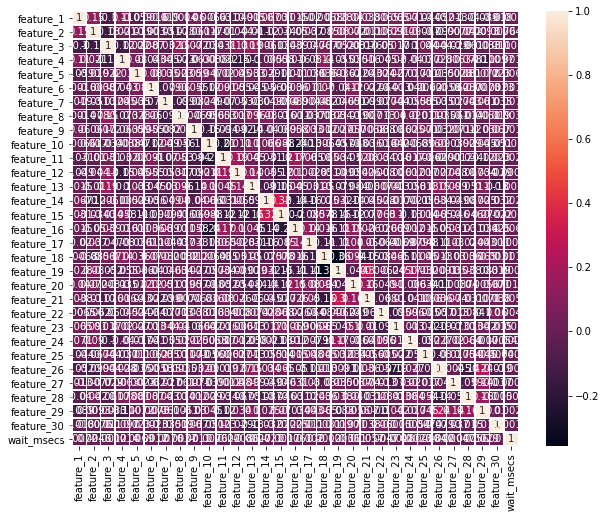

In [157]:
plt.figure(figsize=(10, 8))
sns.heatmap(merged_df.corr(), annot=True, linewidths=.5)

In [158]:
merged_df['wait_msecs'] = merged_df.wait_msecs.apply(lambda x: '0-3S' if x <= 3000 else '3-5S' if x <= 5000 else '5-7S' if x <= 7000 else '7+S')

In [159]:
train, test = train_test_split(merged_df, test_size=0.2, random_state = 180)

In [160]:
model = DecisionTreeClassifier().fit(train.drop('wait_msecs', axis = 1), train.wait_msecs)

In [161]:
prediction = model.predict(test.drop('wait_msecs', axis = 1))

In [162]:
print(metrics.classification_report(test.wait_msecs, prediction, digits=3))

              precision    recall  f1-score   support

        0-3S      0.640     0.970     0.771     60889
        3-5S      0.404     0.068     0.117     15230
        5-7S      0.273     0.025     0.046      6948
         7+S      0.490     0.131     0.207     16933

    accuracy                          0.625    100000
   macro avg      0.452     0.299     0.285    100000
weighted avg      0.553     0.625     0.526    100000

